In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest

import some_routines as sr
# Just for in this notebook
from tqdm import tqdm_notebook as tqdm

# 1. Normally distributed pseudo-random numbers

#### a) Write a RNG that returns a float $\in$ [0,1]. At minimum, use some combination of MWC and XOR-shift. Plot the numbers against each other. Also plot the value for the first 1000 numbers vs the index of the number. Finally have your code generate a million random numbers and plot the result of binning these in 20 bins 0.05 wide.

In [2]:
seed = 19231923
print (f"User seed is set to {seed}")

User seed is set to 19231923


In [3]:
class RandomGenerator(object):
    """
    Random generator should be an object because it maintains
    internal state between calls.
    """
    def __init__(self, seed):
        # make sure the everyhing is an unsigned 64 bit integer
        dtyp = np.uint64
        # the seed for the LGC
        self.X1 = dtyp(seed)
        # the seed for the XORshift
        self.X2 = dtyp(seed)
        # the seed for the MWC, has to be smaller than 2**32
        self.X3 = dtyp(seed)
        if self.X3 >= 2**32:
            raise ValueError("Please provide a seed smaller than 2**32")
        
        self.max_value = dtyp(2**64 - 1)
        
        # LCG values from Numerical Recipies
        self.a = dtyp(1664525)
        self.c = dtyp(1013904223)
        self.m = dtyp(2**32)
        
        # 64 bit XOR shift values from Numerical Recipes
        self.a1, self.a2, self.a3 = dtyp(21), dtyp(35), dtyp(4)
        
        # MWC values from Numerical Recipes
        self.a2 = dtyp(4294957665)
        self.maxx = dtyp(2**32-1)
        self.shift = dtyp(32)
        
    def lincongen(self, X):    
        return (self.a*X+self.c) % self.m

    def XORshift64(self, X):
        if X == 0:
            raise ValueError("Seed cannot be zero")
        X = X ^ (X >> self.a1)
        X = X ^ (X << self.a2)
        X = X ^ (X >> self.a3)
        
        return X
    
    def MWC(self, X):
        X = self.a2*(X & self.maxx) + (X >> self.shift)
        # Use as a random number only lowest 32 bits
        # But in a bitmix, we can use all 64 bits.
        return X
    
    def get_randomnumber(self):
        """
        Combine LCG and XORshift to produce random float 
        between 0 and 1
        """
        self.X1 = self.lincongen(self.X1)
        self.X2 = self.XORshift64(self.X2)
        self.X3 = self.MWC(self.X3)
        
        # output is XOR of these numbers
        
        return ((self.X1^self.X3)^self.X2)/self.max_value
    
        

In [4]:
RNGESUS = RandomGenerator(seed=seed)

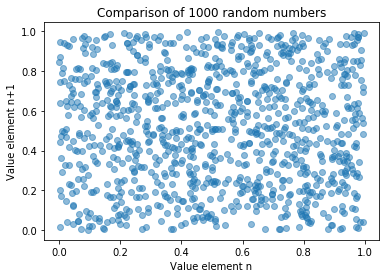

In [5]:
# Generate 1000 random numbers. Plot comparison
all_randnum = np.zeros(1000)
for i in range(1000):
    all_randnum[i] = RNGESUS.get_randomnumber()

plt.plot(all_randnum,np.roll(all_randnum,1),'o',alpha=0.5)
plt.title(f'Comparison of {len(all_randnum)} random numbers')
plt.xlabel('Value element n')
plt.ylabel('Value element n+1')
plt.savefig('./plots/q1a1.png')
plt.show()
plt.close()

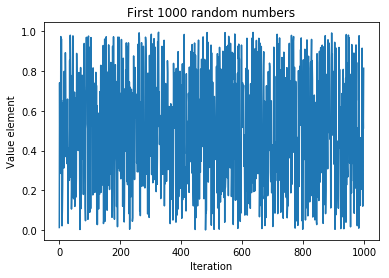

In [6]:
plt.plot(all_randnum)
plt.title(f'First {len(all_randnum)} random numbers')
plt.ylabel('Value element')
plt.xlabel('Iteration')
plt.savefig('./plots/q1a2.png')
plt.show()
plt.close()

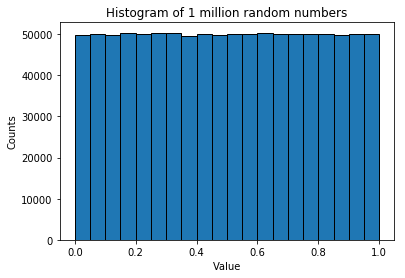

In [7]:
# Now generate 1 million random numbers. Plot histogram
all_randnum = np.zeros(int(1e6))
for i in range(int(1e6)):
    all_randnum[i] = RNGESUS.get_randomnumber()

plt.hist(all_randnum,bins=sr.linspace(0,1,21),edgecolor='black')
plt.title(f'Histogram of 1 million random numbers')
plt.xlabel('Value')
plt.ylabel('Counts')
plt.savefig('./plots/q1a3.png')
plt.show()
plt.close()

#### b. Now use the Box-Muller method to generate 1000 normally distributed random numbers.

In [8]:
def BoxMuller(randnums):
    """
    Given an input of an even number of 
    random numbers drawn from Unif(0,1)
    Return the same amount of random numbers drawn from Gaussian(0,1)
    """
    z1, z2 = randnums[:len(randnums)//2], randnums[len(randnums)//2:]
    a = np.sqrt(-2*np.log(z1))
    x1 = a*np.cos(2*np.pi*z2)
    x2 = a*np.sin(2*np.pi*z2)
    
    randnums2 = np.concatenate([x1,x2])
    
    return randnums2

def GaussianTransform(x,mu,sigma):
    """
    Takes x's drawn from a standard normal distribution and maps them 
    to arbitrary x ~ G(mu,sigma)
    """
    x *= sigma
    x += mu
    return x

def GaussianPdf(x,mean,sigma):
    """return the PDF of a Gaussian"""
    variance = sigma**2
    return 1/(np.sqrt(2*np.pi*variance)) * np.exp(-0.5*(x-mean)**2/variance)


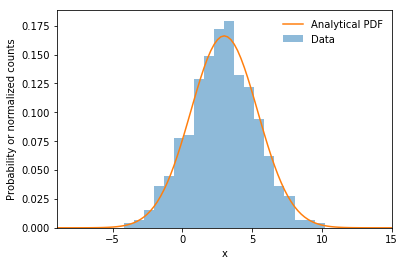

In [9]:
# We can use the first 1000 random numbers we have generated
randgauss = BoxMuller(all_randnum[:1000])
mu, sigma = 3, 2.4
randgauss = GaussianTransform(randgauss,mu,sigma)
# 20 equal width bins
hbins = sr.linspace(mu-3*sigma, mu+3*sigma,21)
nperbin, _, _ = plt.hist(randgauss,bins=hbins,label='data')
plt.close() # We could also set density is true, but since I am unsure
    # whether this is allowed, we shall normalize it manually.
bin_centers = (hbins[:-1] + hbins[1:])/2
binwidths = (hbins[1:] - hbins[:-1])
# Divide each bin by its width
# And divide by the total count to normalize
nperbin /= binwidths*np.sum(nperbin)

# Normalized histogram
plt.bar(bin_centers,nperbin,binwidths,label='Data',alpha=0.5)
# Analytical pdf
xs = sr.linspace(mu-5*sigma,mu+5*sigma,101)
plt.plot(xs, GaussianPdf(xs,mu,sigma),label='Analytical PDF',c='C1')

plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel('Probability or normalized counts')
plt.xlim(mu-5*sigma,mu+5*sigma)
plt.savefig('./plots/q1b1.png')
plt.show()
# plt.close()

#### c. Write a code that can do the KS-test on your function to determine whether it is consistent with a normal dist. For this, use $\mu=0$ and $\sigma=1$. Make a plot of the probability that your Gaussian random number generator is consistent with Gaussian distributed random numbers. Start with 10 random numbers and use in the plot a spacing of 0.1 dex until you have calculated it for $10^5$ random numbers on the x-axis. Compare your algorithm with the KS test from scipy by making another plot with the result from your KS-test and the KS-test from scipy.

The CDF of the standard normal distribution is given by
\begin{equation}
\Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x e^{-t^2/2} dt
\end{equation}

This can be written as 
\begin{equation}
\Phi(x) = \frac{1}{2} \left( 1+\mathrm{erf}\left(\frac{x}{\sqrt{2}} \right) \right)
\end{equation}

Where erf($x$) is called the error function. It is defined as 
\begin{equation}
\mathrm{erf}(x) = \frac{2}{\sqrt{\pi}} \int_{0}^x e^{-t^2} dt
\end{equation}

We calculate this error function by means of Romberg integration.

In [10]:
def romberg(func, lbound, ubound, order=6, relacc=1e-14):
    """
    Calculate the integral of a function using Romberg's method
    with equal spaced abscissae
    
    func   -- function which gives the y values
    lbound -- lower bound of integral
    ubound -- upper bound of integral
    order  -- Amount of steps combining trapezoids, 
    		  final step will have 2**order intervals
    relacc -- target relative accuracy
    
    Returns 
    Value of the integral
    Error estimates at every step
     
    The error estimate is given as the difference between last 2 orders
    """
    
    # for saving the relative error
    relerror = [] # one value per column of the Romberg table
    # for saving S_i,j's
    all_S = np.zeros((order,order))
    
    i = 0
    delta_x = (ubound-lbound)
    points = sr.linspace(lbound,ubound,2**i+1)
    integral = delta_x/2 * np.sum(func(points))
    all_S[0,0] = integral
    
    # Calculate the first column (S_{i,0})
    for i in range(1,order):
        delta_x /= 2
        # add points in the middle
        points = sr.linspace(lbound,ubound,2**i+1)
        # add new points to the integral (use slicing to alternate)
        integral = 0.5*integral + delta_x * np.sum(func(points[1::2]))
        
        all_S[i,0] = integral
    
    # Calculate all others by combining
    for j in range(1,order): # column of Romberg table
        for i in range(j,order): # row of Romberg table
            all_S[i,j] = (4**j*all_S[i,j-1] - all_S[i-1,j-1]) / (
                           4**j - 1)
        # Relative error estimate is difference between last 
        # two estimates divided by the estimate 
        relerror.append(np.abs(1 - all_S[i,j-1]/all_S[i,j]) )
        if relerror[-1] < relacc:
#             print (f"Target relative error of {relacc} reached at S_{i,j}")
            # Target error reached, can stop
            return all_S[i,j], relerror
        
        if len(relerror) > 2:
            if relerror[-1] > relerror[-2]:
#                 print (f"Error increased at at S_{i,j}")
                # error increased, should stop
                return all_S[i,j],relerror        
    
    return all_S[order-1,order-1], relerror

def GaussianCdf(x):
    """
    Calculate the Gaussian CDF at point(s) x    
    """
    
    # the error function is the integral of this erfarg
    # from 0 to x/sqrt(2), multiplied by 2/sqrt(pi)
    erfarg = lambda t: np.exp(-t**2)
    
    if type(x) == np.ndarray or type(x) == list:
        if type(x) == list: 
            x = np.array(x)
        cdf = np.zeros(len(x))
        for i, xnow in enumerate(x):
            cdfn = 0.5*(1+2/np.sqrt(np.pi)*romberg(erfarg,0,xnow/np.sqrt(2)
                                              ,order=6)[0])
            cdf[i] = cdfn            
    else:
        cdf = 0.5*(1+2/np.sqrt(np.pi)*romberg(erfarg,0,x/np.sqrt(2)
                                              ,order=6)[0])
    return cdf # returns a float or numpy array

In [11]:
def quicksort(arr):
    """
    Sort array with quicksort
    sorting is performed IN PLACE
    """
    N = len(arr)
    
    # Make sure first/last/middle elements are ordered correctly
    if arr[0] > arr[N-1]: # swap leftmost and rightmost elements
        arr[0], arr[N-1] = arr[N-1], arr[0]
    if arr[(N-1)//2] > arr[N-1]: # swap middle and rightmost element
        arr[(N-1)//2], arr[N-1] = arr[N-1], arr[(N-1)//2]
    if arr[0] > arr[(N-1)//2]: # swap middle and leftmost element
        arr[0], arr[(N-1)//2] = arr[(N-1)//2], arr[0]
    
    i, j = 0, N-1
    pivot = arr[(N-1)//2]
    pivot_position = (N-1)//2
    for _ in range(0,N//2): # Can improve this range()
        while arr[i] < pivot:
            i +=  1
        while arr[j] > pivot:
            j -= 1
        if j <= i:
            break # pointers have crossed
        else:
            if i == pivot_position: # have to keep track of where the pivot is
                pivot_position = j # going to switch them
            elif j == pivot_position:
                pivot_position = i
            # Both i and j found, swap them around the pivot and continue
            arr[i], arr[j] = arr[j], arr[i]
    
    if N > 2:
        # As long as we don't have 1 element arrays, perform quicksort on the subarrays
        leftarr = arr[:pivot_position] # left of the pivot
        rightarr = arr[pivot_position+1:] # right of the pivot        
        quicksort(leftarr)
        quicksort(rightarr)

def KScdf(z):
    """
    Return the CDF of the KS distribution at 'z'
    Used by the function KStest where 'z' is a function of 
    the KS test statistic 'D'
    """
    pi = np.pi
    exp = np.exp
    
    if z < 1.18:
        term = exp(-pi**2/(8*z**2))
        ans = np.sqrt(2*pi)/z 
        ans *= (term + term**9 + term**25)
        
    else:
        term = exp(-2*z**2)
        ans = 1-2*(term-term**4+term**9)
        
    return ans
        
def KStest(x, hCDF, sorted=False):
    """
    Given an array of observations of x drawn from some PDF,
    this function uses the (two-sided) KS test to test whether x 
    follows the null hypothesis CDF
    
    x      -- array:    realisation from some PDF 
    hCDF   -- array:    CDF of null hypothesis evaluated at 'x'
    sorted -- boolean:  whether the data is already sorted
    
    Returns
    D    -- float: KS test statistic
    pval -- float: p-value to reject null hypothesis 
        
    """
    N = len(x)
    
    if not sorted: # Sort x in ascending order to approximate the ECDF
        # Find the index that sorts the current points
        indices = quickargsort(x)
        # Sort the current points
        x = x[indices]    
        # Make sure to swap the null hypothesis CDF values equivalently
        hcDF = hCDF[indices]

    # empirical cdf
    ECDF = sr.linspace(1,N,N)/N
    # Maximum distance above
    Dplus = sr.findmax(ECDF-hCDF)
    # Maximum distance below, use the right points of the CDF
    Dmin = sr.findmax(hCDF - sr.linspace(0,N-1,N)/N)
    
    # KS test statistic D, in a two-sided test, is the maximum of these
    D = sr.findmax([Dmin,Dplus])
    
    sqN = np.sqrt(N)
    z = (sqN+0.12+0.11/sqN)*D
    pval = 1-KScdf(z)
    
    return D, pval

def Kuiperpvalue(lamb,acc=1e-8,maxIT=100):
    """
    Returns the p value of the Kuiper test given the right lamb
    See the function KuiperTest for the definition of lamb 
    in terms of the Kuiper statistic V.
    
    Uses a series for the asymptotic distribution of the statistic V
    See Numerical Recipes (3rd Edition) Equation (14.3.23)
    """
    if lamb < 0.4:
        return 1.0 # accurate to 7 digits
    else:
        diff = acc+1
        j = 0
        Q = 0
        while diff > acc:
            j += 1
            Qold = Q
            Q += (4*j**2*lamb**2-1)*np.exp(-2*j**2*lamb**2)
            diff = np.abs(Q-Qold)

            
            if j > maxIT:
                print (f"Not converged to the required accuracy of {acc}")
                break           
    return 2*Q
    
def KuiperTest(x, hCDF, sorted=False):
    """
    Given an array of observations of x drawn from some PDF,
    this function uses the KS test to test whether x 
    follows the null hypothesis CDF
    
    x      -- array:    realisation from some PDF 
    hCDF   -- array:    CDF of null hypothesis evaluated at 'x'
    sorted -- boolean:  whether the data is already sorted
    
    Returns
    V    -- float: Kuiper test statistic
    pval -- float: p-value to reject null hypothesis 
        
    """
    N = len(x)
    
    if not sorted: # Sort x in ascending order to approximate the ECDF
        # Find the index that sorts the current points
        indices = quickargsort(x)
        # Sort the current points
        x = x[indices]    
        # Make sure to swap the null hypothesis CDF values equivalently
        hcDF = hCDF[indices]
    
    # empirical cdf
    ECDF = sr.linspace(1,N,N)/N
    # Maximum distance above
    distance = ECDF-hCDF
    Dplus = sr.findmax(distance) 
    # Maximum distance below
    distance = hCDF-ECDF
    Dminus = sr.findmax(distance)
    V = Dplus + Dminus
    
    sqN = np.sqrt(N)
    lamb = (sqN+0.155+0.24/sqN)*V
    pval = Kuiperpvalue(lamb)
    
    return V, pval


def KStest_2sample(x1, x2, sorted=False):
    """
    Compute the 2 sample KS Test on two datasets
    
    x1     -- array:    realisation from some PDF 
    x2     -- array:    realisation from some PDF
    sorted -- boolean:  whether the data is already sorted
    
    Returns
    D    -- float: KS test statistic
    pval -- float: p-value to reject null hypothesis 
        
    """
    N1 = len(x1)
    N2 = len(x2)
    
    if not sorted: # Sort data in ascending order to approximate the ECDF
        # quicksort is performed in place, so copy data first
        x1 = quicksort(np.copy(x1))
        x2 = quicksort(np.copy(x2))

    # empirical cdf of both functions as function of their datapoints
    ECDF1 = sr.linspace(1,N1,N1)/N1
    ECDF2 = sr.linspace(1,N2,N2)/N2
    
    D = 0 # Maximum distance between ECDFs
    i, j = 0, 0
    while (i < (N1-1)) and (j < (N2-1)): # Loop through both arrays
        # CDF of x1 is to the left of x2, increment x1
        while (x1[i] <= x2[j]) and (i < (N1-1)):
            i += 1
        # CDF of x2 is to the left of x1, increment x2
        while (x2[j] <= x1[i]) and (j < (N2-1)):
            j += 1
        # Distance between where we currently are in the CDFs
        dist = np.abs(ECDF1[i]-ECDF2[j]) 
        if dist > D:
            D = dist
    
    sqN = np.sqrt(N1*N2/(N1+N2))
    z = (sqN+0.12+0.11/sqN)*D
    pval = 1-KScdf(z)
    
    return D, pval
    
def KuiperTest_2sample(x1, x2, sorted=False):
    """
    Compute the 2 sample Kuiper Test on two datasets
    
    x1     -- array:    realisation from some PDF 
    x2     -- array:    realisation from some PDF
    sorted -- boolean:  whether the data is already sorted
    
    Returns
    V    -- float: Kuiper test statistic
    pval -- float: p-value to reject null hypothesis 
        
    """        
    N1 = len(x1)
    N2 = len(x2)
    
    if not sorted: # Sort data in ascending order to approximate the ECDF
        # quicksort is performed in place, so copy data first
        x1 = quicksort(np.copy(x1))
        x2 = quicksort(np.copy(x2))

    # empirical cdf of both functions as function of their datapoints
    ECDF1 = sr.linspace(1,N1,N1)/N1
    ECDF2 = sr.linspace(1,N2,N2)/N2
    
    # Maximum distance above and below ECDFs
    Dminus = 0 
    Dplus = 0
    i, j = 0, 0
    while (i < (N1-1)) and (j < (N2-1)): # Loop through both arrays
        # CDF of x1 is to the left of x2, increment x1
        while (x1[i] <= x2[j]) and (i < (N1-1)):
            i += 1
        # CDF of x2 is to the left of x1, increment x2
        while (x2[j] <= x1[i]) and (j < (N2-1)):
            j += 1
        # Distance between where we currently are in the CDFs
        distp = ECDF1[i]-ECDF2[j]
        distm = ECDF2[j]-ECDF1[i]
        if distp > Dplus:
            Dplus = distp
        if distm > Dminus:
            Dminus = distm
    
    # Kuiper's statistic
    V = Dplus + Dminus
    
    sqN = np.sqrt(N1*N2/(N1+N2))
    lamb = (sqN+0.155+0.24/sqN)*V
    pval = Kuiperpvalue(lamb)
    
    return V, pval

In [12]:
def quickargsort(arr):
    """
    Argsort with quicksort.
    
    This function works by creating an additional axis to the array
    which saves the indices, and swaps them along with the elements
    
    The subfunction quicksort is equivalent to the 'real' quicksort
    except that it uses some smarter slicing. Note that the original
    input array is not modified in this function
    
    Returns
    indices -- integer array of the indices that would sort the array
    """
    # Store indices to swap them along with the elements
    indices = list(range(0,len(arr)))
    # Make sure to copy arr, since it will get swapped in place
    newarr = np.array([np.copy(arr),indices]).T # shape (10,2)
    
    def quicksort(arr):
        """
        Quicksort adjusted for index sorting
        """
        N = len(arr)

        # Make sure first/last/middle elements are ordered correctly
        if arr[0,0] > arr[N-1,0]: # swap leftmost and rightmost elements
            # Use advanced slicing to swap along rows
            # (since normal slicing now creates views instead of copies)
            arr[[0,N-1],:] = arr[[N-1,0],:]
        if arr[(N-1)//2,0] > arr[N-1,0]: # swap middle and rightmost element
            arr[[(N-1)//2,N-1],:] = arr[[N-1,(N-1)//2],:]
            
        if arr[0,0] > arr[(N-1)//2,0]: # swap middle and leftmost element
            arr[[0,(N-1)//2],:] =  arr[[(N-1)//2,0],:]

        i, j = 0, N-1
        pivot = arr[(N-1)//2,0]
        pivot_position = (N-1)//2
        for _ in range(0,N//2): # Can improve this range()
            while arr[i,0] < pivot:
                i +=  1
            while arr[j,0] > pivot:
                j -= 1
            if j <= i:
                break # pointers have crossed
            else:
                if i == pivot_position: # have to keep track of where the pivot is
                    pivot_position = j # going to switch them
                elif j == pivot_position:
                    pivot_position = i
                # Both i and j found, swap them around the pivot and continue
                arr[[i,j],:] = arr[[j,i],:]

        if N > 2:
            # As long as we don't have 1 element arrays, perform quicksort on the subarrays
            leftarr = arr[:pivot_position] # left of the pivot
            rightarr = arr[pivot_position+1:] # right of the pivot        
            quicksort(leftarr)
            quicksort(rightarr)
    
    # Call the subfunction on the array with the additional axis
    quicksort(newarr)
    # return only the indices
    return np.array(newarr[:,1],dtype='int') 

For Kuiper's test, we use the formula for the asymptotic distribution of the Kuiper's statistic $V$ from the Numerical Recipes book \citep{TODO}. Here $Q_{KP}$ is defined as

\begin{equation}
Q_{KP}(\lambda) = 2\sum_{j=1}^{\infty} (4j^2\lambda^2-1)e^{-2j^2\lambda^2}.
\end{equation}
This function is 1, to 7 figures for $\lambda < 0.4$, so we hard-code the function to return this. The $p$-value for Kuiper's test is then
\begin{equation}
p = Q_{KP} \left( [\sqrt{N} + 0.155 +0.24/\sqrt{N}]V\right)
\end{equation}


In [13]:
# In Question 2 we need 1024**2 standard normal random numbers, 
# since we already have a million now, we might as well generate 
# a few more and save them for Question 2
N = 1024
amount = N**2-len(randgauss) # amount we need to generate
new_randnum = np.zeros(amount)
for i in range(amount):
    new_randnum[i] = RNGESUS.get_randomnumber()
all_randnum = np.concatenate([new_randnum,all_randnum])

# transform all random numbers drawn to standard normal dist
randgauss = BoxMuller(all_randnum)
# save these so we can use them later
np.save('./1MrandSN.npy', randgauss)    

# For Question 1, we only need the first 100,000
randgauss = randgauss[:100000]

A spacing of 0.1 dex means we increase by a factor $10^{0.1}$. So, to get up to $10^5$ starting from $10^1$, we have to increase by this factor 40 times

In [14]:
# Load the data for question e already so we can do question c,d,e
# all in the same loop.

# 10 sets of 100,000 random numbers
data = np.loadtxt('./randomnumbers.txt') # shape(int(1e5),10)

In [15]:
# TEST CELL
from scipy.stats import ks_2samp

In [16]:
import time
t = time.time()
# my values
all_D = np.zeros(41)
all_p = np.zeros(41)
# scipy values
all_D_sp = np.zeros(41)
all_p_sp = np.zeros(41)

all_numpoints = np.zeros(41)

# Make the same plot for the Kuipers test
all_D_kuiper = np.zeros(41)
all_p_kuiper = np.zeros(41)

# 2 sample KS test for the datasets
all_D_2s_KS = np.zeros((41,10))
all_p_2s_KS = np.zeros((41,10))
# 2 sample Kuiper's test
all_D_2s_kuiper = np.zeros((41,10))
all_p_2s_kuiper = np.zeros((41,10))

# Calculate CDF of the standard normal once in advance
hCDF = GaussianCdf(randgauss[:100000])

# A spacing of 0.1 dex means we increase by a factor $10^{0.1}$.
# So, to get up to $10^5$ starting from $10^1$, we have to increase 
# by this factor 40 times
for i in tqdm(range(41)):
    numpoints = int(10*10**(0.1*i))
    all_numpoints[i] = (numpoints)

    # Find the index that sorts the current points
    indices = quickargsort(randgauss[:numpoints])
    # Sort the current points
    curpoints = randgauss[:numpoints][indices]    
    # Sort CDF at the points that we will evaluate equivalently
    curCDF = hCDF[:numpoints][indices]
    
    # Tell the KS test that we already sorted the points
    D, pval = KStest(curpoints,curCDF,sorted=True)
    all_D[i] = D
    all_p[i] = pval
    # define a lambda function so scipy works without new calculations
    CDFprecalc = lambda x: curCDF
    D, pval = kstest(curpoints,CDFprecalc)
    all_D_sp[i] = D
    all_p_sp[i] = pval
    
    # Perform the Kuiper test 
    D, pval = KuiperTest(curpoints, curCDF, sorted=True)
    all_D_kuiper[i] = D
    all_p_kuiper[i] = pval
    
    # Compare our random numbers the 10 sets of random numbers too
    for j in range(data.shape[1]):
        curdata = np.copy(data[:numpoints,j])
        # Sort the data, since we have already sorted our own points
        quicksort(curdata)
        # Calculate two sample tests
        D, pval = KStest_2sample(curpoints, curdata, sorted=True)
        all_D_2s_KS[i,j] = D
        all_p_2s_KS[i,j] = pval
        
        D, pval = KuiperTest_2sample(curpoints, curdata, sorted=True)
        all_D_2s_kuiper[i,j] = D
        all_p_2s_kuiper[i,j] = pval   
            
print (f"Took {time.time()-t} seconds")


Took 161.3102331161499 seconds


We see that our generated random numbers agree with being drawn from a normal distribution and that the results of our KS test match the results of the KS test implemented in scipy, except for the calculation of the $p$-value for a low number of datapoints. This is because the series that we have used to calculate the CDF of the KS-distribution is asymptotically accurate as the number of samples becomes large. At low number of samples it performs quite well too, but this is what causes the difference with the p-values from scipy at a low number of points. We can see that the statistic matches perfectly, and the p-value for more than 50 datapoints matches very well too. 

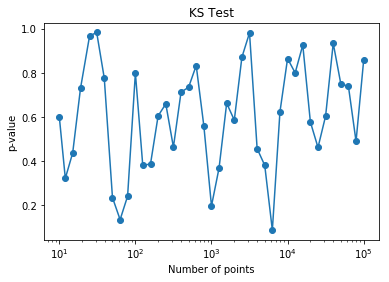

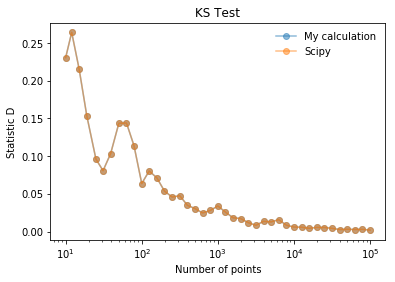

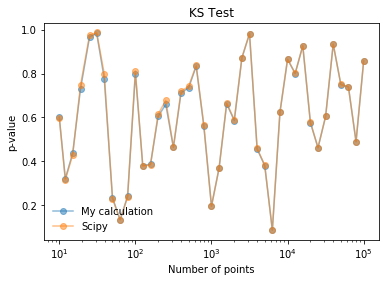

In [17]:
# Make a plot of the probability that it is consistent with Gaussian
plt.plot(all_numpoints,all_p,'-o')
plt.xlabel('Number of points')
plt.ylabel('p-value')
plt.title("KS Test")
plt.xscale('log')
plt.savefig('./plots/q1c1.png')
plt.show()

# Make a plot to compare the statistic with scipy
plt.plot(all_numpoints,all_D,'-o',label='My calculation',alpha=0.5)
plt.plot(all_numpoints,all_D_sp,'-o',label='Scipy',alpha=0.5)
plt.xlabel('Number of points')
plt.ylabel('Statistic D')
plt.title("KS Test")
plt.xscale('log')
plt.legend(frameon=False)
plt.savefig('./plots/q1c2.png')
plt.show()

# Make a plot to compare the p-value with scipy
plt.plot(all_numpoints,all_p,'-o',label='My calculation',alpha=0.5)
plt.plot(all_numpoints,all_p_sp,'-o',label='Scipy',alpha=0.5)
plt.xlabel('Number of points')
plt.ylabel('p-value')
plt.title("KS Test")
plt.xscale('log')
plt.legend(frameon=False)
plt.savefig('./plots/q1c3.png')
plt.show()



In [18]:
# Test cell
# np.allclose(all_D,all_D_sp,1e-10)
# tst = np.array(all_D)
# tst2 = np.array(all_D_sp)
# indxs = tst == tst2
# print (np.where(tst != tst2))

# for i in range(np.sum(np.invert(indxs))):
#     print (tst[np.invert(indxs)][i]-tst2[np.invert(indxs)][i])

# print ("...")
# # print (tst,tst2)
# for i in range(np.sum((indxs))):
#     print (tst[(indxs)][i]-tst2[(indxs)][i])


#### d) Write a code that does the Kuiper's test on your random numbers and make the same plot as for the KS-test.

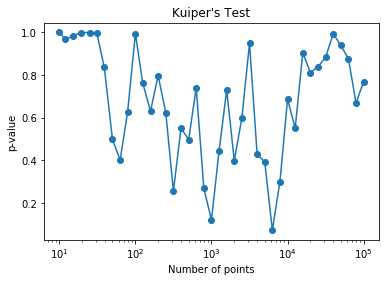

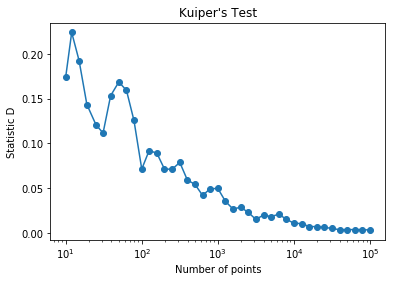

In [19]:
# Make a plot of the probability that it is consistent with Gaussian
plt.plot(all_numpoints,all_p_kuiper,'-o')
plt.xlabel('Number of points')
plt.ylabel('p-value')
plt.title("Kuiper's Test")
plt.xscale('log')
plt.savefig('./plots/q1d1.png')
plt.show()

# Make a plot to compare the statistic with scipy
plt.plot(all_numpoints,all_D_kuiper,'-o')
plt.xlabel('Number of points')
plt.ylabel('Statistic D')
plt.title("Kuiper's Test")
plt.xscale('log')
plt.savefig('./plots/q1d2.png')
plt.show()

#### e) Download a dataset. This dataset contains 10 sets of random numbers. Compare these 10 sets with your Gaussian pseudo random numbers and make the same plot of the probability in as in either of the previous two exercises (your choice). Which random number array(s) is are consistent with standard normal random numbers?

0.07999999999999996
0.41623999999999983
0.9999999998535081


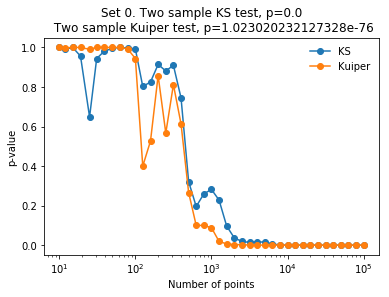

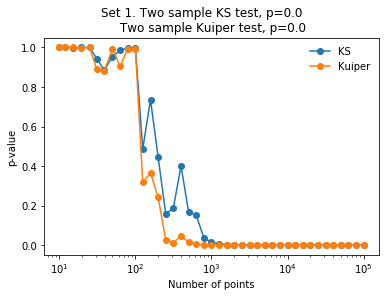

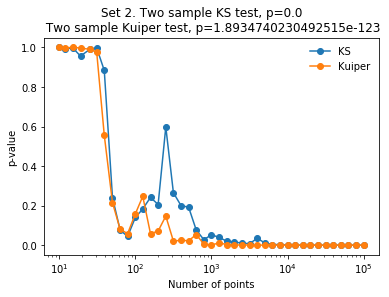

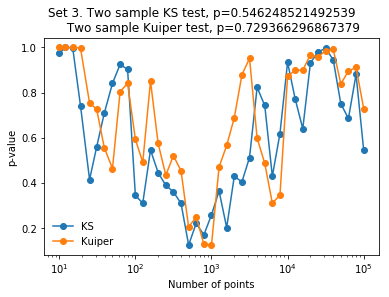

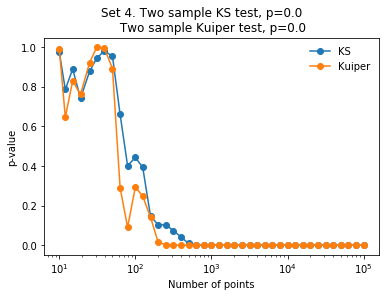

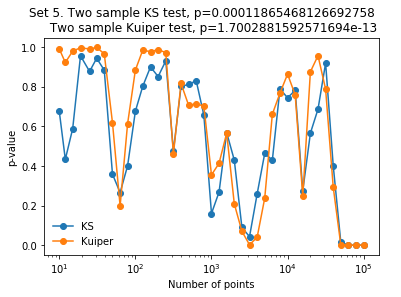

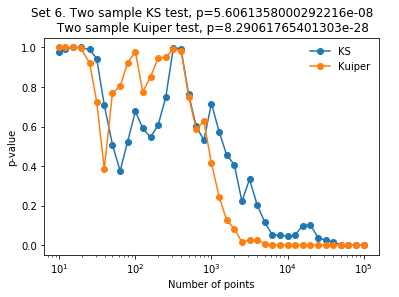

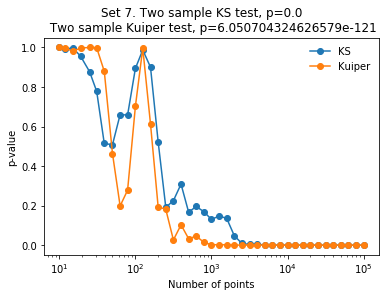

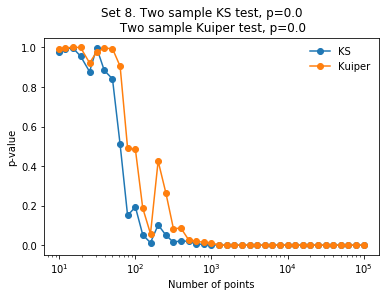

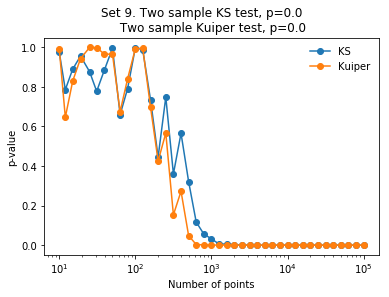

In [20]:
# See above for the calculations

V = all_D_2s_kuiper[7,0]
print (V)
N = all_numpoints[7]
sqN = np.sqrt(N*N/(N+N))
lamb = (sqN+0.155+0.24/sqN)*V
print (lamb)
print (all_p_2s_kuiper[7,0])


for ds in range(data.shape[1]):

#     plt.plot(all_numpoints, all_D_2s_KS[:,ds],'o-')
#     plt.plot(all_numpoints, all_D_2s_KS_sp[:,ds],'o-',label='sp')
#     plt.xlabel('Number of points')
#     plt.ylabel('Statistic D')
#     plt.title(f"Two sample KS test, D={all_D_2s_KS[-1,ds]}")
#     plt.xscale('log')
#     plt.legend()
#     # plt.savefig('./plots/q1e1.png')
#     plt.show()   

    # Make a plot of the probability that it is consistent with Gaussian
    plt.plot(all_numpoints,all_p_2s_KS[:,ds],'-o',label='KS')
    plt.plot(all_numpoints,all_p_2s_kuiper[:,ds],'-o',label='Kuiper')
    plt.xlabel('Number of points')
    plt.ylabel('p-value')
    plt.title(f"Set {ds}. Two sample KS test, p={all_p_2s_KS[-1,ds]} \
    \n Two sample Kuiper test, p={all_p_2s_kuiper[-1,ds]}")
    plt.xscale('log')
    plt.legend(frameon=False)
    # plt.savefig('./plots/q1e2.png')
    plt.show()

#     plt.plot(all_numpoints, all_D_2s_kuiper[:,ds],'o-')
#     plt.xlabel('Number of points')
#     plt.ylabel('Statistic D')
#     plt.title(f"Two sample Kuiper Test, V={all_D_2s_kuiper[-1,ds]}")
#     plt.xscale('log')
#     # plt.savefig('./plots/q1e1.png')
#     plt.show()   

#     # Make a plot of the probability that it is consistent with Gaussian
#     plt.plot(all_numpoints,all_p_2s_kuiper[:,ds],'-o')
#     plt.xlabel('Number of points')
#     plt.ylabel('p-value')
#     plt.title(f"Set {ds}. Two sample Kuiper Test, p={all_p_2s_kuiper[-1,ds]}")
#     plt.xscale('log')
#     # plt.savefig('./plots/q1e2.png')
#     plt.show()

For most sets, we can see that the $p$-value drops very low (basically to 0) for $>10^3$ datapoints, calculated with both the 2 sample KS test and the 2 sample Kuiper test. The only two sets that are interesting are set 3 and set 5. However, when considering the full extent of set 5, the resulting $p$-value also indicates that it is inconsistent with a standard normal distribution. The only set with a $p$-value above the often used threshold of 0.05 is set 3 (the fourth set). Thus we can conclude that all datsets except set 3 are inconsistent with our own Gaussian random numbers with $\sigma=1$ and $\mu=0$ and that set 3 is consistent with Gaussian random numbers with $\sigma=1$ and $\mu=0$.